# **MNIST Keras Classifier**

#Importing necessary libraries

In [ ]:
import pandas as pd
import sys, numpy as np
import requests, gzip, os, hashlib
from keras.datasets import mnist
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools    
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


#Load data

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
x_train.size

47040000

In [ ]:
x_test.size

7840000

In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
x_test.shape

(10000, 28, 28)

In [ ]:
sns.set(style='white', context='notebook', palette='deep')

#Input Normalization

In [ ]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [ ]:
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)
x_train = x_train.astype('float32')

#One hot encoding

In [ ]:
def convert_to_one_hot_encoding(labels, columns):
  one_hot_labels = np.zeros((len(labels),columns))
  for i, j in enumerate(labels):
    one_hot_labels[i][j] = 1
  return one_hot_labels

In [ ]:
train_labels = convert_to_one_hot_encoding(y_train, 10)

In [ ]:
test_labels = convert_to_one_hot_encoding(y_test, 10)

#Convolutional Neural Network

In [ ]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation = 'relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)         

In [ ]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.1)

In [ ]:
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [ ]:
epochs = 40
batch_size = 80

#Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

#Fitting the model

In [ ]:
nn = model.fit(datagen.flow(x_train, train_labels, batch_size=batch_size),
                              epochs = epochs, verbose = 1, validation_data = (x_test, test_labels), shuffle=True, steps_per_epoch=x_train.shape[0] // batch_size)
                              # , callbacks=[learning_rate_reduction])

Epoch 1/5
750/750 [==============================] - 420s 560ms/step - loss: 0.4645 - accuracy: 0.8559 - val_loss: 0.1438 - val_accuracy: 0.9573
Epoch 2/5
750/750 [==============================] - 415s 553ms/step - loss: 0.4422 - accuracy: 0.8630 - val_loss: 0.1365 - val_accuracy: 0.9600
Epoch 3/5
750/750 [==============================] - 412s 549ms/step - loss: 0.4246 - accuracy: 0.8687 - val_loss: 0.1308 - val_accuracy: 0.9612
Epoch 4/5
750/750 [==============================] - 409s 546ms/step - loss: 0.4151 - accuracy: 0.8726 - val_loss: 0.1267 - val_accuracy: 0.9617
Epoch 5/5
750/750 [==============================] - 409s 545ms/step - loss: 0.4022 - accuracy: 0.8759 - val_loss: 0.1243 - val_accuracy: 0.9623


###Accuracy achieved is 96%.

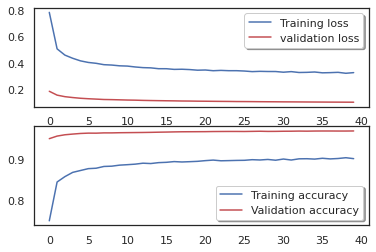

In [ ]:
# plotting the metrics
fig, ax = plt.subplots(2,1)
ax[0].plot(nn.history['loss'], color='b', label="Training loss")
ax[0].plot(nn.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(nn.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(nn.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

#Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='MNIST Confusion Matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center',color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True MNIST Label')
    plt.xlabel('MNIST Predicted Label')

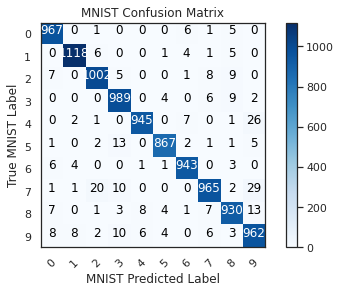

In [ ]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(test_labels,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

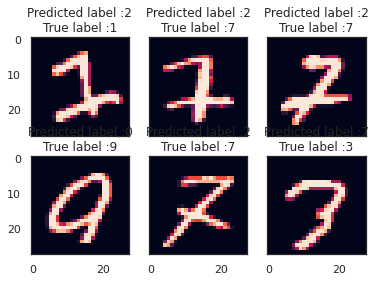

In [ ]:
# Displaying error results, that is difference between predicted labels and true labels

errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = x_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)